<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_008_mushroom_dendogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
import numpy as np
print(np.__version__)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
1.26.4


In [ ]:
# Dependencies
import numpy as np
import scipy
import os
import re
import string
import pandas as pd
from collections import Counter
import sklearn
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
!pip install gensim
from gensim.models import Word2Vec

In [ ]:
!pip install ucimlrepo
!pip install subgroups
from ucimlrepo import fetch_ucirepo


In [ ]:
!git clone https://github.com/uef-machine-learning/tspgclu.git
%cd tspgclu
!pip install -r requirements.txt
!pip install .
!python python/ex_cluster.py


fatal: destination path 'tspgclu' already exists and is not an empty directory.
/content/tspgclu
Processing /content/tspgclu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tspg: filename=tspg-1.0-cp311-cp311-linux_x86_64.whl size=536184 sha256=1bef75d97d3996e04ec9fcaffd6135b68f51a332a5fabd2619250ec34fa6a1ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-uwze9l0s/wheels/76/b6/67/20b88094c0a7504d3e162a7729d9ab59dad6b547bc230d033f
Successfully built tspg
  Attempting uninstall: tspg
    Found existing installation: tspg 1.0
    Uninstalling tspg-1.0:
      Successfully uninstalled tspg-1.0
tspg_py 0020
py_TSPgClu
N=5000 D=2
 664159.000000 550946.000000
 665845.000000 557965.000000
 597173.000000 575538.000000
 618600.000000 551446.000000
 635690.000000 608046.000000
 588100.000000 557588.000000
 582015.000000 546191.000000
 604678.000000

In [ ]:
#SDUEBA Parameters:
"""
vector_space_dimension  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""

vector_space_dimension = 36
clustering_method = "agglomerative"      #"agglomerative"/"spherical_kmeans"/"tspg"
#One of these two has to be None, for kmeans dendogram_cut = None
n_clusters = None
dendogram_cut = 0.05


max_depth = 2
test_size = 0.2
tree_accuracy_threshold = 0.95

target_value = 'poisonous'

#Quality metric parameters
description_length_limit = 2
difference_limit = 0
subgroup_size_limit = 10


In [ ]:
#Data augemntation

def preprocess_mushroom_data(df):

    mapping = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no bruises'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

    for column, mapping in mapping.items():
        df[column] = df[column].replace(mapping)

    return df

mapping_targets = {'p': 'poisonous', 'e': 'edible'}

data = fetch_ucirepo(id=73)
features_raw = preprocess_mushroom_data(pd.DataFrame(data=data.data.features))
target_df = pd.DataFrame(data=data.data.targets)
target_df.columns = ['class']
target_df['class'] = target_df['class'].map(mapping_targets)
# features_raw.head()

In [ ]:
#Data augemntation sentence creation
#TRAINING ON ALL DATA!!!
training_df = pd.merge(features_raw, target_df, left_index=True, right_index=True)

for column in training_df.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)
    training_df[column] = training_df[column].apply(lambda x: f"{jointed_columns} is {x}")

sentences = []
for i in range(len(training_df)):
    sentence = []
    for word in training_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

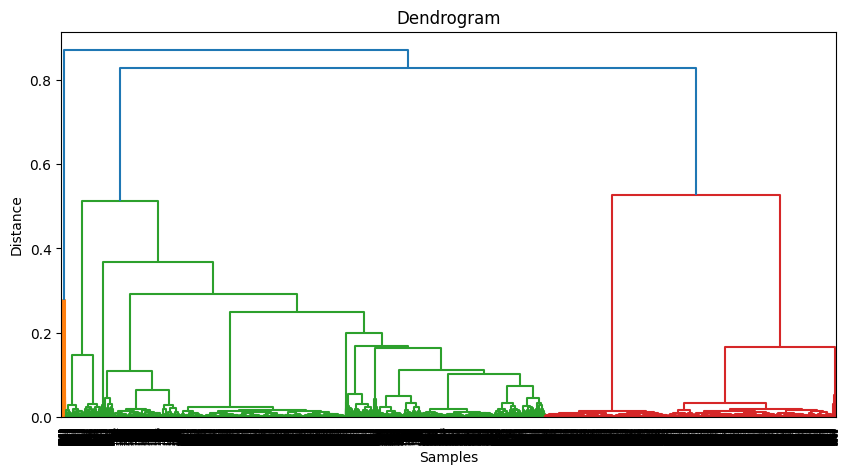

In [ ]:
#Word2Vec training and clustering
#https://journalofbigdata.springeropen.com/articles/10.1186/s40537-024-01053-x
import tspg
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

class Word2VecModel:
    def __init__(self, sentences, vector_size, window=5, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        return np.mean(word_embeddings, axis=0) if word_embeddings else np.zeros(self.model.vector_size)

class SentenceEmbedder:
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def generate_embeddings(self, sentences, normalize=False):
        embeddings = np.array([self.word2vec_model.get_embedding(sentence) for sentence in sentences])
        return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) if normalize else embeddings

class ClusteringModel:
    def __init__(self, n_clusters=None, method="spherical_kmeans", random_state=42, dendrogram_cut=None):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.dendrogram_cut = dendrogram_cut
        self.model = None
        self.linkage_matrix = None
        self._initialize_model()

    def _initialize_model(self):
        if self.method == "agglomerative":
            self.model = AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average')
        elif self.method == "spherical_kmeans":
            self.model = None  # Spherical KMeans will be handled within this class
        elif self.method == "tspg":
            self.model = self
        else:
            raise ValueError("Unsupported clustering method")

    def fit_predict(self, embeddings):
        if self.method == "agglomerative":
            return self._agglomerative_clustering(embeddings)
        elif self.method == "tspg":
            return self._tspg_clustering(embeddings)
        elif self.method == "spherical_kmeans":
            return self._spherical_kmeans_clustering(embeddings)
        return self.model.fit_predict(embeddings)

    def _spherical_kmeans_clustering(self, X):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        cluster_centers = X[indices]

        for _ in range(200):
            similarities = X @ cluster_centers.T
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([
                normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                if np.any(labels == j) else cluster_centers[j]
                for j in range(self.n_clusters)
            ]).squeeze()

            if np.linalg.norm(new_centroids - cluster_centers) < 1e-4:
                break

            cluster_centers = new_centroids

        return labels

    def _agglomerative_clustering(self, embeddings):
        self.linkage_matrix = linkage(embeddings, method='average', metric='cosine')
        if self.dendrogram_cut:
            labels = fcluster(self.linkage_matrix, self.dendrogram_cut, criterion='distance')
        else:
            labels = AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average').fit_predict(embeddings)
        return labels

    def _tspg_clustering(self, embeddings):
        self.linkage_matrix = linkage(embeddings, method='ward')
        if self.dendrogram_cut:
            labels = fcluster(self.linkage_matrix, self.dendrogram_cut, criterion='distance')
            labels = [x - 1 for x in labels]
        else:
            labels, _ = tspg.tspg(embeddings.tolist(), self.n_clusters, distance="cos", num_tsp=30, dtype="vec")
            labels = [x - 1 for x in labels]
        return np.array(labels)

    def plot_dendrogram(self):
        if self.linkage_matrix is None:
            raise ValueError("Dendrogram is not available. Fit the model first using agglomerative or tspg method.")
        plt.figure(figsize=(10, 5))
        dendrogram(self.linkage_matrix)
        plt.title("Dendrogram")
        plt.xlabel("Samples")
        plt.ylabel("Distance")
        plt.show()


word2vec_model = Word2VecModel(sentences, vector_size=vector_space_dimension)
sentence_embedder = SentenceEmbedder(word2vec_model)
embeddings = sentence_embedder.generate_embeddings(sentences, normalize=True)

clustering_model = ClusteringModel(n_clusters=n_clusters, method=clustering_method, dendrogram_cut=dendogram_cut)
labels = clustering_model.fit_predict(embeddings)

clustering_model.plot_dendrogram()

In [ ]:
#Decision tree training
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)
        X = features_classify.drop(columns=['cluster'])
        X_encoded = self.encoder.fit_transform(X)
        y = features_classify['cluster']

        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )

    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

tree_trainer = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)

In [ ]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    difference = abs(tp / (tp + fp) - (TP / (TP + FP)))
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    return difference / description_length

class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold, mixed_threshold=0.8):
        self.data_frame = data_frame
        self.target_df = target_df
        self.mixed_threshold = mixed_threshold
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self._classify_and_extract_rules()

    def _extract_rules_from_tree(self, tree, node=0, rule_list=None, rule_path=None):
        if rule_list is None:
            rule_list = []
        if rule_path is None:
            rule_path = []

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            class_probabilities = value[0] / value.sum()
            predicted_class = class_probabilities.argmax()
            if predicted_class == 1:
                rule_list.append(" AND ".join(rule_path))
            return rule_list

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, rule_list, rule_path + [f"{self.feature_names[feature]} <= {threshold:.2f}"])

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, rule_list, rule_path + [f"{self.feature_names[feature]} > {threshold:.2f}"])

        return rule_list

    def _classify_and_extract_rules(self):
        cluster_class_counts = {}
        for i, cluster in enumerate(self.cluster_labels):
            class_label = self.target_df['class'][i]
            cluster_class_counts.setdefault(cluster, {}).setdefault(class_label, 0)
            cluster_class_counts[cluster][class_label] += 1

        N = len(self.target_df)
        class_counts = {class_: sum(self.target_df['class'] == class_) for class_ in set(self.target_df['class'])}
        cluster_classifications, n_dict = {}, {}

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            class_percentages = {cls: round(count / total_count, 2) for cls, count in class_counts.items()}
            dominant_class, dominant_count = max(class_counts.items(), key=lambda x: x[1])
            relative_frequency = dominant_count / total_count
            classification = dominant_class if relative_frequency >= self.mixed_threshold else 'mixed'

            cluster_classifications[cluster] = classification
            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = class_percentages
            self.tp_dict[cluster] = dominant_count
            self.fp_dict[cluster] = total_count - dominant_count
            n_dict[cluster] = total_count

            self.TP_dict[cluster] = class_counts.get(dominant_class, 0)
            self.FP_dict[cluster] = N - self.TP_dict[cluster]

            self.WRAcc_dict[cluster] = ((self.tp_dict[cluster] + self.fp_dict[cluster]) / N) * (self.tp_dict[cluster] / n_dict[cluster] - self.TP_dict[cluster] / N)

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy lower than the given threshold"]
                else:
                    rules_list = self._extract_rules_from_tree(self.decision_trees[cluster])
                    self.rules_dict[cluster] = rules_list if rules_list else self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)



    def print_summary(self):
        print("\nFormatted Cluster Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            percentages_str = ", ".join(f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items())
            rules = self.rules_dict.get(cluster, None)

            if rules is None:
                rules = ["No rules extracted"]

            print(f"Cluster {cluster}: support = {self.cluster_frequencies[cluster]}, {percentages_str}, WRAcc = {self.WRAcc_dict[cluster]}")

            for rule in rules:
                print(f"  - {rule}")

        print("\nUnextractable Clusters:", self.unextractable_clusters)


clusters = ClusterRuleExtractor(
    data_frame=training_df,
    target_df=target_df,
    cluster_labels=labels,
    feature_names=list(tree_trainer.X_df.columns),
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold
)
clusters.print_summary()


Formatted Cluster Summary:
Cluster 1: support = 18, 'poisonous': 1.0, WRAcc = 0.0022107481743463757
  - stalk-color-above-ring_cinnamon > 0.50 AND gill-attachment_attached > 0.50
Cluster 2: support = 18, 'poisonous': 1.0, WRAcc = 0.0022107481743463757
  - stalk-color-above-ring_cinnamon > 0.50 AND gill-attachment_attached <= 0.50
Cluster 3: support = 2, 'poisonous': 1.0, WRAcc = 0.00024612353910740005
  - No rules extracted
Cluster 4: support = 6, 'poisonous': 1.0, WRAcc = 0.0007380069775205148
  - No rules extracted
Cluster 5: support = 192, 'edible': 1.0, WRAcc = 0.0230751272557486
  - stalk-color-above-ring_orange > 0.50
Cluster 6: support = 192, 'edible': 1.0, WRAcc = 0.0230751272557486
  - habitat_waste > 0.50
Cluster 7: support = 16, 'edible': 1.0, WRAcc = 0.0019655943413768033
  - stalk-surface-above-ring_scaly > 0.50
Cluster 8: support = 104, 'poisonous': 0.69, 'edible': 0.31, WRAcc = 0.00874917362855067
  - spore-print-color_green > 0.50
Cluster 9: support = 512, 'edible': 1.

In [ ]:
class SubgroupCreator:
    def __init__(self, X_df, targets_df, target_value):
        self.X_df = X_df
        self.targets_df = targets_df
        self.target_value = target_value
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_coverage = 0
        self.subgroup_descriptions = {}

    def evaluate_rule(self, rule_str, covered_indices_set):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []

        for part in parts:
            feature, operator, value = part.rsplit(maxsplit=2)
            value = float(value)

            if ">" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} = '{category_value}'")
                mask &= self.X_df[feature] > 0.5

            elif "<=" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} ≠ '{category_value}'")
                mask &= self.X_df[feature] <= 0.5

        covered_indices = set(self.X_df[mask].index) - covered_indices_set
        covered_indices_set.update(covered_indices)
        covered_targets = self.targets_df.loc[list(covered_indices)]

        tp = (covered_targets == self.target_value).sum().item()
        fp = (covered_targets != self.target_value).sum().item()
        TP = (self.targets_df == self.target_value).sum().item()
        FP = (self.targets_df != self.target_value).sum().item()

        WRAcc = ((tp + fp) / (TP + FP)) * ((tp / (tp + fp)) - (TP / (TP + FP)))

        return tp, fp, TP, FP, WRAcc, covered_indices, description

    def evaluate_all_clusters(self, subgroups):
        with open("results_SDUEBA.txt", "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    covered_indices_set = set()

                    for idx, rule_str in enumerate(rules_list):
                        letter_index = string.ascii_lowercase[idx]
                        subgroup_label = f"{cluster}.{letter_index}"

                        tp, fp, TP, FP, WRAcc, covered_indices, description = self.evaluate_rule(rule_str, covered_indices_set)

                        self.tp_dict[subgroup_label] = tp
                        self.fp_dict[subgroup_label] = fp
                        self.TP_dict[subgroup_label] = TP
                        self.FP_dict[subgroup_label] = FP
                        self.WRAcc_dict[subgroup_label] = WRAcc
                        self.subgroups[subgroup_label] = covered_indices
                        self.total_coverage += tp + fp

                        description_str = ", ".join(str(item) for item in description)
                        self.Quality_dict[subgroup_label] = Quality_metric(
                            tp=tp,
                            fp=fp,
                            TP=TP,
                            FP=FP,
                            description_length=len(description),
                            description_length_limit=description_length_limit,
                            difference_limit=difference_limit,
                            subgroup_size_limit=subgroup_size_limit,
                        )
                        self.subgroup_descriptions[subgroup_label] = description_str


                        f.write(
                            f"Description: [{description_str}], Target: class = '{self.target_value}' ; "
                            f"QuMe = {float(self.Quality_dict[subgroup_label]) if self.Quality_dict[subgroup_label] is not None else 0:.8f} ; "
                            f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                            f"tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                        )
            f.write(f"Total coverage: {self.total_coverage / len(self.targets_df)}\n")


evaluator = SubgroupCreator(tree_trainer.X_df, target_df, target_value=target_value)
evaluator.evaluate_all_clusters(clusters)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


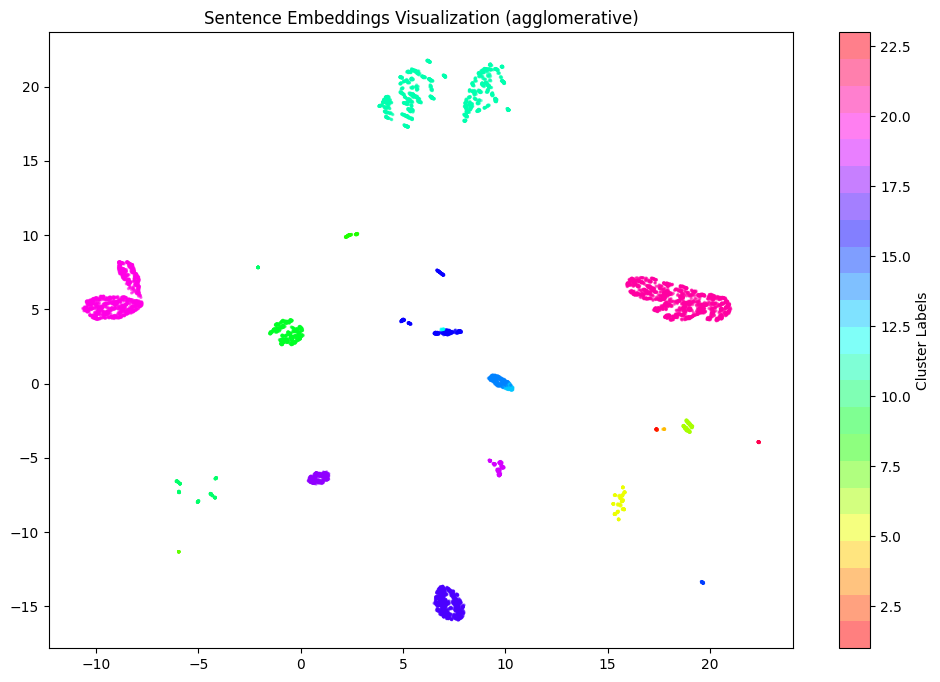

In [ ]:
# Clusters visualization
import umap
def plot_sentence_embeddings(embeddings, cluster_labels, clustering_method=None):
    plt.figure(figsize=(12, 8))

    reducer = umap.UMAP(n_components=2, random_state=73, n_neighbors=200, min_dist=0.1, metric='cosine')
    embeddings_2d = reducer.fit_transform(np.array(embeddings))

    cluster_labels = np.array(cluster_labels)

    cmap = plt.get_cmap('hsv', len(set(cluster_labels)))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=cmap, alpha=0.5, s=2)

    plt.colorbar(scatter, label='Cluster Labels')
    plt.title(f"Sentence Embeddings Visualization ({clustering_method})")
    plt.show()

plot_sentence_embeddings(embeddings, cluster_labels=labels, clustering_method=clustering_method)

In [ ]:
%%time
from subgroups.algorithms import BSD
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1

dataset = pd.concat([features_raw, target_df], axis=1).astype(str)
target = ('class', target_value)
#num_subgroups=50!!!!
bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=50, max_depth=2, write_results_in_file = True, file_path = "./results_BSD.txt" )
bsd_model.fit(dataset, target)


CPU times: user 961 ms, sys: 4.01 ms, total: 965 ms
Wall time: 962 ms


In [ ]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    output_file = "results_BSD_.txt"

    with open(file_path, 'r') as file, open(output_file, 'w') as output:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), Target: (.*?) ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+)", line)

            if match:
                description = match.group(1)
                target = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                output_line = f"{description}, Target: {target} ; QuMe = {quality_score:.8f} ; WRAcc = {WRAcc:.8f} ; tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                output.write(output_line)

file_path = "results_BSD.txt"
parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)

In [ ]:
#Overlap ratio
def compute_coverage(filename, quality_measure, k, dataset, print_subgroups=False):
    with open(filename, 'r') as file:
        lines = file.readlines()

    subgroups = []
    instance_coverage = {}

    for line in lines:
        match = re.search(rf"{quality_measure}\s*=\s*([-+]?\d*\.?\d+)\s*;.*tp\s*=\s*(\d+)\s*;\s*fp\s*=\s*(\d+)", line)
        if match:
            quality = float(match.group(1))
            tp = int(match.group(2))
            fp = int(match.group(3))

            desc_match = re.search(r"Description: \[(.*?)\]", line)
            if desc_match:
                description = desc_match.group(1).split(", ")
            else:
                description = []

            mask = pd.Series(True, index=dataset.index)
            for condition in description:
                try:
                    feature, value = condition.split(" = ")
                    value = value.strip("'")

                    if feature not in dataset.columns:
                        continue

                    mask &= dataset[feature] == value
                except ValueError:
                    continue

            covered_instances = set(dataset[mask].index)

            for instance in covered_instances:
                instance_coverage[instance] = instance_coverage.get(instance, 0) + 1

            subgroups.append((quality, covered_instances, description, line.strip()))

    subgroups.sort(reverse=True, key=lambda x: x[0])
    top_k_subgroups = subgroups[:k]

    covered_instances = set()
    filtered_instance_coverage = {}

    for _, instance_ids, _, _ in top_k_subgroups:
        covered_instances.update(instance_ids)
        for instance in instance_ids:
            filtered_instance_coverage[instance] = filtered_instance_coverage.get(instance, 0) + 1

    coverage = len(covered_instances) / len(dataset) if len(dataset) else 0
    overlapping_instances = sum(1 for count in filtered_instance_coverage.values() if count > 1)
    overlap_ratio = overlapping_instances / len(covered_instances) if covered_instances else 0

    if print_subgroups:
        print("Top-k subgroups:")
        for _, _, _, subgroup in top_k_subgroups:
            print(subgroup)

    return coverage, overlap_ratio


print("SDUEBA model:")
coverage_SDUEBA, overlap_SDUEBA = compute_coverage('results_SDUEBA.txt', 'QuMe', 20, features_raw, True)
print(f"Coverage: {coverage_SDUEBA}, Overlap Ratio: {overlap_SDUEBA}")

print("BSD model:")
coverage_BSD, overlap_BSD = compute_coverage('results_BSD_.txt', 'QuMe', 20, features_raw, True)
print(f"Coverage: {coverage_BSD}, Overlap Ratio: {overlap_BSD}")

SDUEBA model:
Top-k subgroups:
Description: [spore-print-color = 'green'], Target: class = 'poisonous' ; QuMe = 0.51797144 ; WRAcc = 0.00459059 ; tp = 72 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [odor = 'pungent'], Target: class = 'poisonous' ; QuMe = 0.51797144 ; WRAcc = 0.01632209 ; tp = 256 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [odor = 'creosote'], Target: class = 'poisonous' ; QuMe = 0.51797144 ; WRAcc = 0.01224157 ; tp = 192 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [ring-type = 'large'], Target: class = 'poisonous' ; QuMe = 0.51797144 ; WRAcc = 0.08263060 ; tp = 1296 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [gill-color = 'buff'], Target: class = 'poisonous' ; QuMe = 0.51797144 ; WRAcc = 0.11017413 ; tp = 1728 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [stalk-color-below-ring = 'yellow'], Target: class = 'poisonous' ; QuMe = 0.51797144 ; WRAcc = 0.00153020 ; tp = 24 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [stalk-color-above-ring = 'orange'], Target: 